# Fake news detection using ML 

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [75]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [76]:
fake.shape

(23481, 4)

In [77]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [78]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [79]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [80]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [81]:
# Check the data
data.head()

,title,text,subject,date,target
0,Bernie Sanders Open To Being Clinton’s V.P. (...,Hillary Clinton is on the path to be the Democ...,News,"May 6, 2016",fake
1,U.S. navy recovers remains of all sailors miss...,SINGAPORE (Reuters) - The U.S. Navy on Monday ...,worldnews,"August 28, 2017",true
2,Federal prosecutors question NYC mayor over fu...,NEW YORK (Reuters) - New York City Mayor Bill ...,politicsNews,"February 24, 2017",true
3,Ex-Christie associates lose bid for new trial ...,NEW YORK (Reuters) - A federal judge rejected ...,politicsNews,"March 2, 2017",true
4,MAXINE WATERS: ‘These people trying to ‘discre...,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,"Jul 22, 2017",fake


In [82]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Bernie Sanders Open To Being Clinton’s V.P. (...,Hillary Clinton is on the path to be the Democ...,News,fake
1,U.S. navy recovers remains of all sailors miss...,SINGAPORE (Reuters) - The U.S. Navy on Monday ...,worldnews,true
2,Federal prosecutors question NYC mayor over fu...,NEW YORK (Reuters) - New York City Mayor Bill ...,politicsNews,true
3,Ex-Christie associates lose bid for new trial ...,NEW YORK (Reuters) - A federal judge rejected ...,politicsNews,true
4,MAXINE WATERS: ‘These people trying to ‘discre...,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,fake


In [83]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Hillary Clinton is on the path to be the Democ...,News,fake
1,SINGAPORE (Reuters) - The U.S. Navy on Monday ...,worldnews,true
2,NEW YORK (Reuters) - New York City Mayor Bill ...,politicsNews,true
3,NEW YORK (Reuters) - A federal judge rejected ...,politicsNews,true
4,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,fake


In [84]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,hillary clinton is on the path to be the democ...,News,fake
1,singapore (reuters) - the u.s. navy on monday ...,worldnews,true
2,new york (reuters) - new york city mayor bill ...,politicsNews,true
3,new york (reuters) - a federal judge rejected ...,politicsNews,true
4,maxine got a makeover and is hopping mad about...,left-news,fake


In [85]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [86]:
# Check
data.head()

,text,subject,target
0,hillary clinton is on the path to be the democ...,News,fake
1,singapore reuters the us navy on monday confi...,worldnews,true
2,new york reuters new york city mayor bill de ...,politicsNews,true
3,new york reuters a federal judge rejected a r...,politicsNews,true
4,maxine got a makeover and is hopping mad about...,left-news,fake


In [87]:
# Removing stopwords
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop = stopwords.words('english')

#data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

from gensim.parsing.preprocessing import remove_stopwords

def remove_stopwords_from_text(text):
    return remove_stopwords(text)

data['text'] = data['text'].apply(remove_stopwords_from_text)


In [88]:
data.head()

,text,subject,target
0,hillary clinton path democratic nominee presid...,News,fake
1,singapore reuters navy monday confirmed recove...,worldnews,true
2,new york reuters new york city mayor blasio me...,politicsNews,true
3,new york reuters federal judge rejected reques...,politicsNews,true
4,maxine got makeover hopping mad speculation s ...,left-news,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


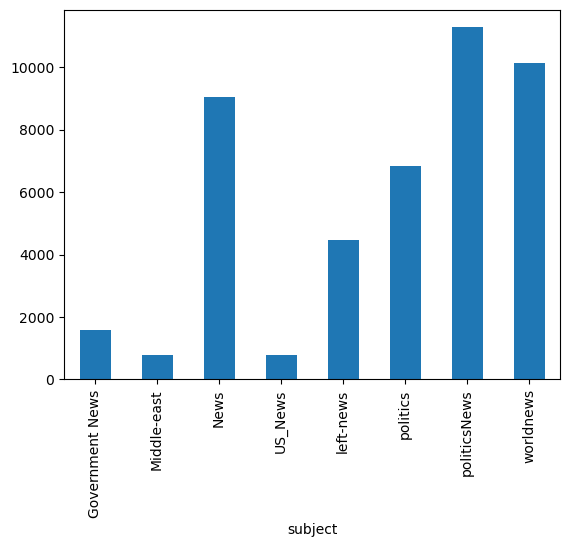

In [89]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


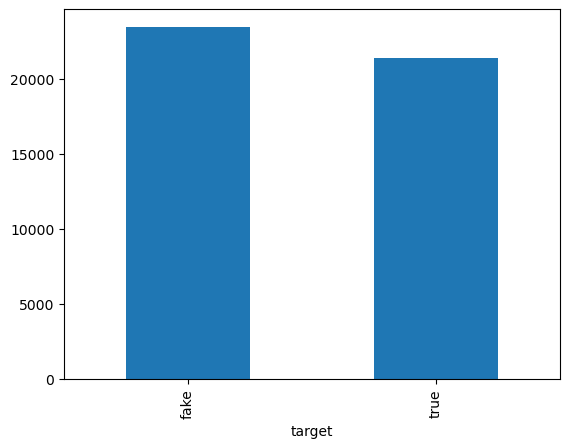

In [90]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

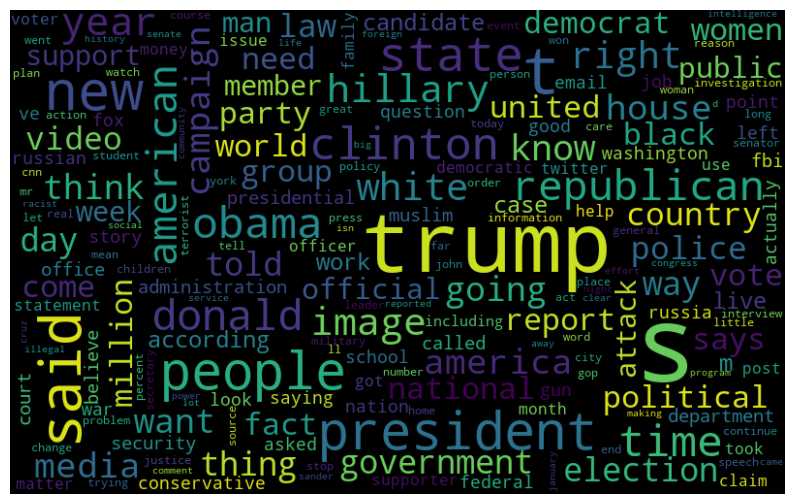

In [91]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

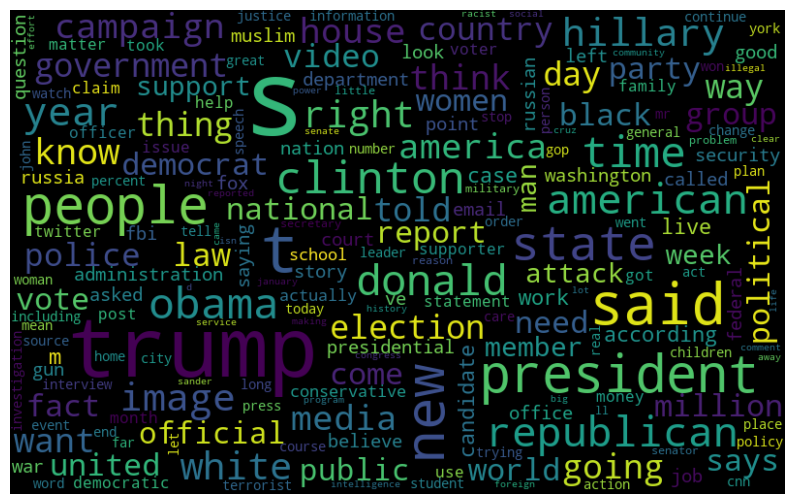

In [92]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [93]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

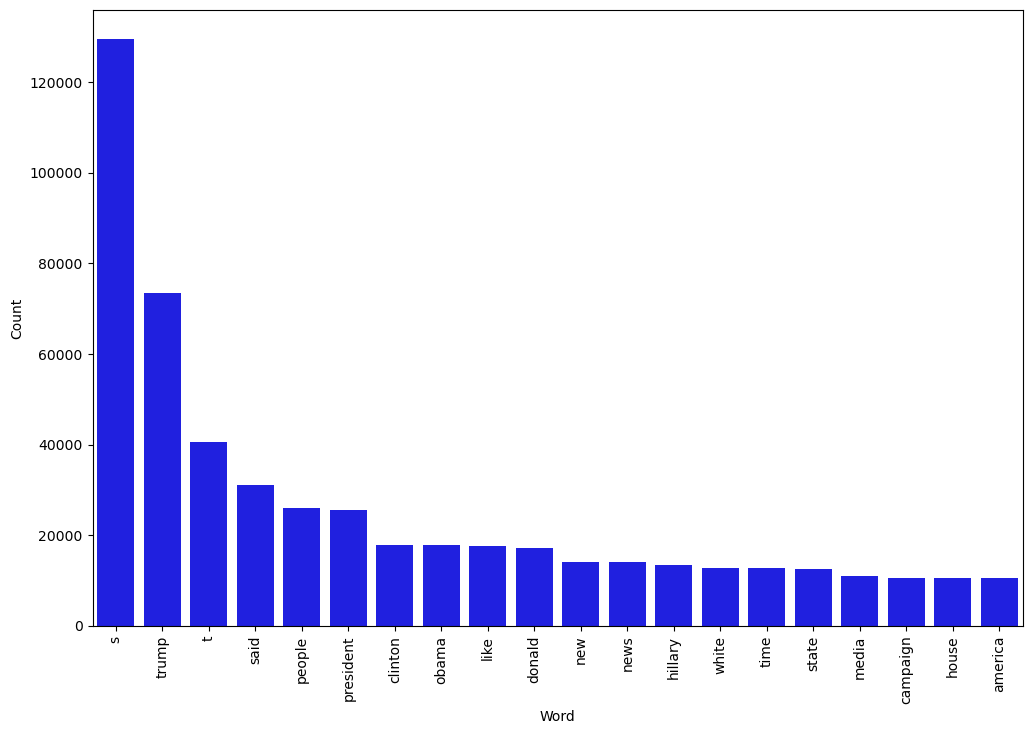

In [94]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

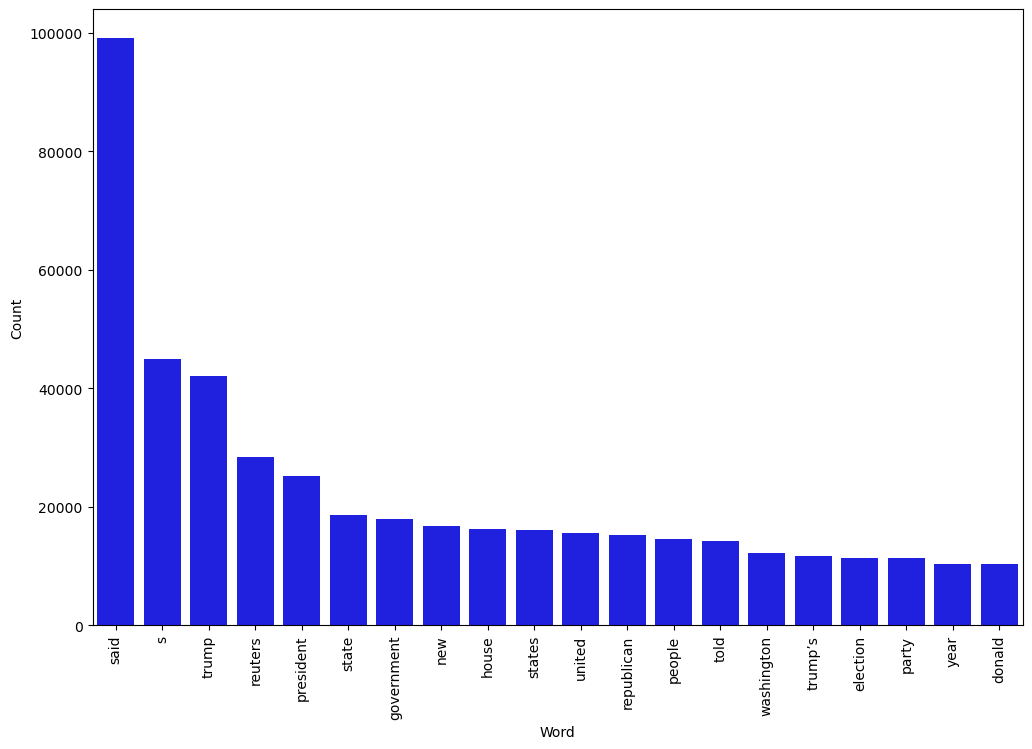

In [95]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [96]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [97]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [98]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.3%


Confusion matrix, without normalization


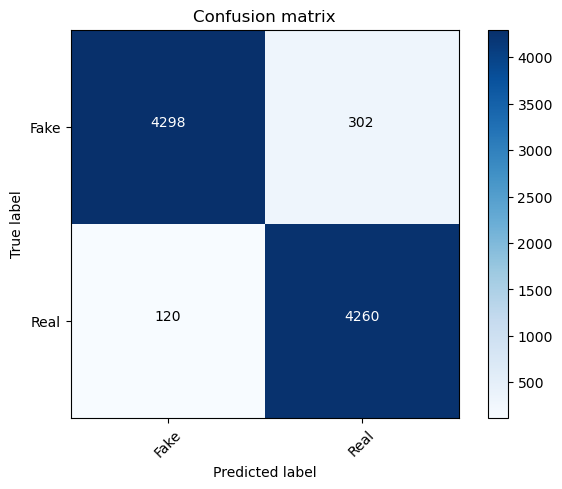

In [99]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [100]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.05%


Confusion matrix, without normalization


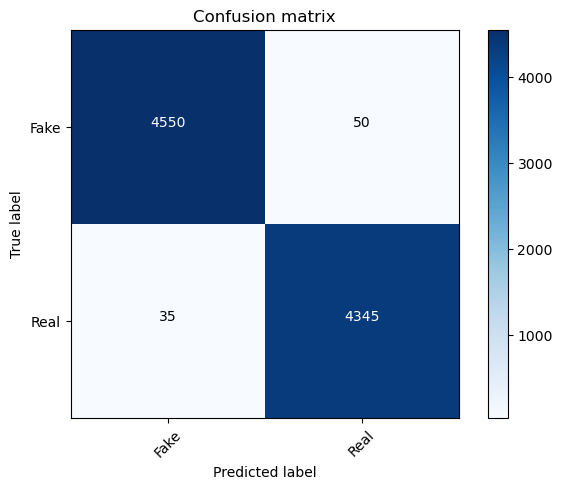

In [101]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.58%


Confusion matrix, without normalization


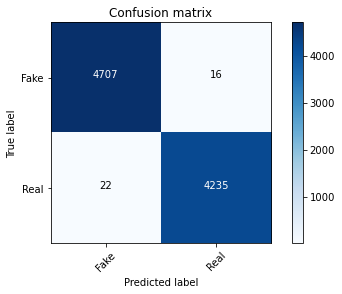

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.3%


Confusion matrix, without normalization


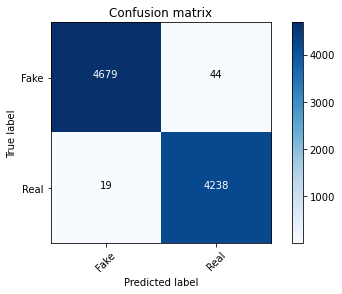

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [33]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 99.44%


Confusion matrix, without normalization


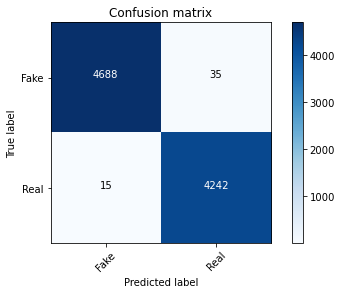

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x18101096a00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

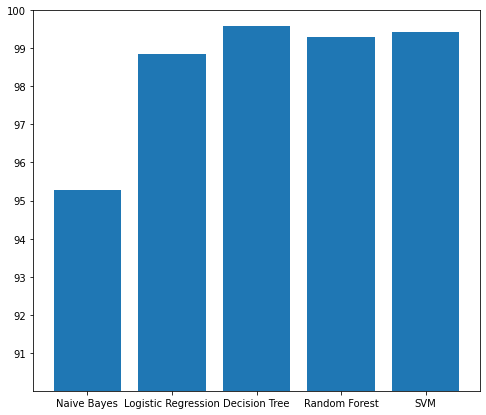

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [50]:
X_new = [X_test.iloc[2]]

prediction = model.predict(X_new)
print(prediction)

if(prediction[0]== 'true' ):
    print("The new is Real")
else:
    print("The new is Fake")

['true']
The new is Real


In [53]:
data.columns

Index(['text', 'subject', 'target'], dtype='object')

In [2]:
data['text'][4]

NameError: name 'data' is not defined

## Saving he trained model

In [56]:
import pickle

In [64]:
filename = 'trained_model.pkl'

with open(filename,"wb+") as f:
    pickle.dumps(model,filename)

TypeError: an integer is required (got type str)

In [66]:
pickle.dump(model,open("trained_model.pkl","wb"))

In [72]:
loaded_model = pickle.load(open("trained_model.pkl","rb"))

In [106]:
X_new = [X_test.iloc[4]]

prediction = loaded_model.predict(X_new)
print(prediction)

if(prediction[0]== 'true' ):
    print("The new is Real")
else:
    print("The new is Fake")

['true']
The new is Real
